In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import seaborn as sns
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

In [2]:
# read in dataset and select columns
terror = pd.read_csv('terrorism_new.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (4,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [312]:
gname_stats = terror[['gname','eventid']]\
.groupby('gname')['eventid']\
.count()\
.to_frame()\
.reset_index()\
.sort_values('eventid',ascending = False)

top_groups = gname_stats[(gname_stats['eventid'] > 100) & (gname_stats['gname'] != "Unknown")]
top_groups = top_groups[['gname']].merge(terror, on = "gname")

In [313]:
len(top_groups.gname.unique())

126

In [314]:
features = []
# feature engineering for groups

# numeric -> aggregation

# categorical -> count for each category

# temporal: frequency of attacks, longest hiatus

In [315]:
mp = {
    "nperps":-99,
    "propvalue":-99,
    "attacktype1":9,
    "targtype1":20,
    "weaptype1":13,
    "gname":"Unknown"
}


def filterColumnsAndRows(df, cols, mapping):
    df = df[cols].dropna()
    for col in cols:
        if col in mapping:
            df = df[df[col] != mapping[col]]
    return df

In [316]:
# numeric - nperps, nkill, nwound
top_groups_f1 = filterColumnsAndRows(top_groups, ['gname','eventid','nperps','nkill','nwound'], mp)
top_groups_f1 = top_groups_f1\
.groupby('gname')['nperps','nkill','nwound']\
.mean()\
.reset_index()

features.append(top_groups_f1)
top_groups_f1

<ipython-input-316-14cc24b3000e>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  top_groups_f1 = top_groups_f1\


,gname,nperps,nkill,nwound
0,Abu Sayyaf Group (ASG),11.972678,1.808743,2.693989
1,African National Congress (South Africa),7.125000,2.458333,6.625000
2,Al-Aqsa Martyrs Brigade,1.784810,2.784810,12.012658
3,Al-Gama'at al-Islamiyya (IG),3.206897,1.310345,1.448276
4,Al-Nusrah Front,1.718750,10.718750,30.031250
...,...,...,...,...
120,Ulster Freedom Fighters (UFF),1.956522,0.913043,0.782609
121,Ulster Volunteer Force (UVF),2.000000,0.950000,0.500000
122,United Liberation Front of Assam (ULFA),3.741379,1.534483,1.793103
123,United Popular Action Movement,4.960000,0.320000,0.440000


In [317]:
# [name for name in top_groups.gname.unique() if name not in top_groups_f1.gname.unique()]
# top_groups[top_groups['gname'] == 'Corsican National Liberation Front- Historic Channel']['nperps']

In [318]:
# categorical - convert to percentage

# attacktype
attack_types = [
    "Armed Assault", "Assassination", "Bombing/Explosion", "Facility/Infrastructure Attack",
    "Hijacking", "Hostage Taking (Barricade Incident)", "Hostage Taking (Kidnapping)",
    "Unarmed Assault", "Unknown"
]
top_groups_atk = top_groups\
.groupby(['gname','attacktype1_txt'])['eventid']\
.count()\
.to_frame()\
.reset_index()

top_groups_atk = pd.pivot_table(top_groups_atk, 
                                values='eventid', 
                                index=['gname'],
                                columns=['attacktype1_txt']).reset_index()
top_groups_atk = top_groups_atk.fillna(0) 
top_groups_atk['total'] = top_groups_atk[attack_types].sum(axis=1)
for attack in attack_types:
    top_groups_atk[attack] = top_groups_atk[attack] / top_groups_atk['total']
    
top_groups_atk = top_groups_atk.drop('total', axis = 1)
top_groups_atk.columns = [
    "gname","atk_armed_assault","atk_assasination","atk_bombing","atk_faci_infra","atk_hijack",
    "atk_host_barr","atk_host_kid","atk_unarmed_assault","atk_unknown"
]
features.append(top_groups_atk)
top_groups_atk

,gname,atk_armed_assault,atk_assasination,atk_bombing,atk_faci_infra,atk_hijack,atk_host_barr,atk_host_kid,atk_unarmed_assault,atk_unknown
0,Abu Sayyaf Group (ASG),0.192101,0.028725,0.384201,0.007181,0.019749,0.003591,0.350090,0.000000,0.014363
1,African National Congress (South Africa),0.087315,0.115321,0.655684,0.001647,0.000000,0.000000,0.000000,0.001647,0.138386
2,Al-Aqsa Martyrs Brigade,0.382857,0.028571,0.508571,0.022857,0.000000,0.005714,0.040000,0.005714,0.005714
3,Al-Gama'at al-Islamiyya (IG),0.413127,0.482625,0.054054,0.038610,0.000000,0.000000,0.000000,0.000000,0.011583
4,Al-Nusrah Front,0.068841,0.021739,0.605072,0.003623,0.000000,0.007246,0.195652,0.007246,0.090580
...,...,...,...,...,...,...,...,...,...,...
121,Ulster Freedom Fighters (UFF),0.111538,0.603846,0.126923,0.142308,0.000000,0.000000,0.000000,0.007692,0.007692
122,Ulster Volunteer Force (UVF),0.159259,0.581481,0.218519,0.007407,0.003704,0.000000,0.011111,0.011111,0.007407
123,United Liberation Front of Assam (ULFA),0.167553,0.026596,0.694149,0.007979,0.000000,0.000000,0.093085,0.000000,0.010638
124,United Popular Action Movement,0.256881,0.119266,0.467890,0.100917,0.018349,0.018349,0.009174,0.000000,0.009174


In [319]:
# weaptype
weap_types = [
    "Chemical", "Explosives", "Fake Weapons", "Firearms", "Incendiary","Melee","Other",
    "Sabotage Equipment","Unknown","Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)"
]
top_groups_weap = top_groups\
.groupby(['gname','weaptype1_txt'])['eventid']\
.count()\
.to_frame()\
.reset_index()

top_groups_weap = pd.pivot_table(top_groups_weap, 
                                values='eventid', 
                                index=['gname'],
                                columns=['weaptype1_txt']).reset_index()
top_groups_weap = top_groups_weap.fillna(0) 
top_groups_weap['total'] = top_groups_weap[weap_types].sum(axis=1)
for weap in weap_types:
    top_groups_weap[weap] = top_groups_weap[weap] / top_groups_weap['total']
    
top_groups_weap = top_groups_weap.drop('total', axis = 1)
top_groups_weap.columns = [
    "gname","wp_chemical", "wp_explosives", "wp_fake", "wp_firearms", "wp_incendiary","wp_melee","wp_other",
    "wp_sabotage_equip","wp_unknown","wp_vehicle"
]
features.append(top_groups_weap)
top_groups_weap

,gname,wp_chemical,wp_explosives,wp_fake,wp_firearms,wp_incendiary,wp_melee,wp_other,wp_sabotage_equip,wp_unknown,wp_vehicle
0,Abu Sayyaf Group (ASG),0.000000,0.411131,0.0,0.470377,0.012567,0.035907,0.0,0.0,0.070018,0.000000
1,African National Congress (South Africa),0.000000,0.673806,0.0,0.128501,0.024712,0.003295,0.0,0.0,0.169687,0.000000
2,Al-Aqsa Martyrs Brigade,0.000000,0.508571,0.0,0.428571,0.011429,0.028571,0.0,0.0,0.017143,0.005714
3,Al-Gama'at al-Islamiyya (IG),0.000000,0.061776,0.0,0.841699,0.000000,0.011583,0.0,0.0,0.084942,0.000000
4,Al-Nusrah Front,0.007246,0.663043,0.0,0.123188,0.007246,0.014493,0.0,0.0,0.184783,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
121,Ulster Freedom Fighters (UFF),0.000000,0.123077,0.0,0.661538,0.153846,0.034615,0.0,0.0,0.023077,0.003846
122,Ulster Volunteer Force (UVF),0.003704,0.222222,0.0,0.681481,0.018519,0.055556,0.0,0.0,0.018519,0.000000
123,United Liberation Front of Assam (ULFA),0.000000,0.707447,0.0,0.255319,0.002660,0.007979,0.0,0.0,0.026596,0.000000
124,United Popular Action Movement,0.000000,0.431193,0.0,0.403670,0.128440,0.000000,0.0,0.0,0.036697,0.000000


In [320]:
# targtype
targ_types = [
    "Abortion Related","Airports & Aircraft", "Business", "Educational Institution","Food or Water Supply",
    "Government (Diplomatic)", "Government (General)", "Journalists & Media", "Maritime","Military",
    "NGO", "Other", "Police", "Private Citizens & Property", "Religious Figures/Institutions",
    "Telecommunication", "Terrorists/Non-State Militia", "Tourists", "Transportation", "Unknown", "Utilities", 
    "Violent Political Party"
]
top_groups_targ = top_groups\
.groupby(['gname','targtype1_txt'])['eventid']\
.count()\
.to_frame()\
.reset_index()

top_groups_targ = pd.pivot_table(top_groups_targ, 
                                values='eventid', 
                                index=['gname'],
                                columns=['targtype1_txt']).reset_index()
top_groups_targ = top_groups_targ.fillna(0) 
top_groups_targ['total'] = top_groups_targ[targ_types].sum(axis=1)
for targ in targ_types:
    top_groups_targ[targ] = top_groups_targ[targ] / top_groups_targ['total']
    
top_groups_targ = top_groups_targ.drop('total', axis = 1)
top_groups_targ.columns = [
    "gname", "tg_abortion","tg_air", "tg_business", "tg_edu","tg_food_water",
    "tg_gov_dip", "tg_gov_gen", "tg_media", "tg_maritime","tg_military",
    "tg_ngo", "tg_other", "tg_police", "tg_private", "tg_religious",
    "tg_telecom", "tg_terror_militia", "tg_tourists", "tg_transport", "tg_unknown", "tg_utilities", 
    "tg_violent_pp"
]
features.append(top_groups_targ)
top_groups_targ

,gname,tg_abortion,tg_air,tg_business,tg_edu,tg_food_water,tg_gov_dip,tg_gov_gen,tg_media,tg_Mmritime,tg_military,tg_ngo,tg_other,tg_police,tg_private,tg_religious,tg_telecom,tg_terror_militia,tg_tourists,tg_transport,tg_unknown,tg_utilities,tg_violent_pp
0,Abu Sayyaf Group (ASG),0.000000,0.003591,0.159785,0.044883,0.003591,0.000000,0.105925,0.012567,0.057451,0.175943,0.012567,0.001795,0.053860,0.238779,0.039497,0.001795,0.001795,0.016158,0.032316,0.032316,0.005386,0.000000
1,African National Congress (South Africa),0.000000,0.001647,0.095552,0.001647,0.003295,0.008237,0.199341,0.001647,0.000000,0.105437,0.000000,0.000000,0.369028,0.054366,0.001647,0.001647,0.000000,0.000000,0.056013,0.000000,0.075783,0.024712
2,Al-Aqsa Martyrs Brigade,0.000000,0.000000,0.085714,0.005714,0.000000,0.011429,0.045714,0.017143,0.000000,0.154286,0.000000,0.000000,0.022857,0.525714,0.011429,0.000000,0.000000,0.000000,0.074286,0.045714,0.000000,0.000000
3,Al-Gama'at al-Islamiyya (IG),0.000000,0.000000,0.131274,0.000000,0.000000,0.000000,0.023166,0.000000,0.007722,0.000000,0.000000,0.003861,0.613900,0.119691,0.011583,0.000000,0.003861,0.030888,0.050193,0.003861,0.000000,0.000000
4,Al-Nusrah Front,0.000000,0.000000,0.032609,0.007246,0.000000,0.007246,0.050725,0.057971,0.000000,0.373188,0.003623,0.000000,0.043478,0.311594,0.043478,0.000000,0.039855,0.000000,0.010870,0.014493,0.000000,0.003623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,Ulster Freedom Fighters (UFF),0.003846,0.003846,0.211538,0.007692,0.000000,0.000000,0.057692,0.000000,0.000000,0.007692,0.000000,0.000000,0.015385,0.569231,0.007692,0.000000,0.103846,0.000000,0.003846,0.003846,0.000000,0.003846
122,Ulster Volunteer Force (UVF),0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.014815,0.000000,0.000000,0.007407,0.677778,0.007407,0.000000,0.107407,0.003704,0.007407,0.007407,0.000000,0.000000
123,United Liberation Front of Assam (ULFA),0.000000,0.000000,0.162234,0.007979,0.000000,0.000000,0.061170,0.000000,0.000000,0.042553,0.000000,0.000000,0.148936,0.297872,0.002660,0.002660,0.013298,0.000000,0.063830,0.077128,0.111702,0.007979
124,United Popular Action Movement,0.000000,0.000000,0.155963,0.045872,0.000000,0.018349,0.100917,0.027523,0.000000,0.009174,0.000000,0.000000,0.302752,0.036697,0.275229,0.000000,0.000000,0.000000,0.009174,0.000000,0.000000,0.018349


In [321]:
# binary: 'success','claimed','suicide'
bin_cols = ['success','suicide']
for col in bin_cols:
    df = top_groups\
    .groupby(['gname', col])['eventid']\
    .count()\
    .to_frame()\
    .reset_index()

    df = pd.pivot_table(df, 
                        values='eventid', 
                        index=['gname'],
                        columns=[col]).reset_index()
    df['total'] = df[[0,1]].sum(axis=1)
    df[1] = df[1] / df['total']
    df = df.drop([0,'total'],axis=1)
    df.columns = ['gname', col]
    df = df.fillna(0)
    features.append(df)


In [322]:
# 'property','propvalue'
top_groups_prop = top_groups\
.groupby(['gname','property'])['eventid','propvalue']\
.agg({
    'eventid': 'count',
    'propvalue': 'mean'
})\
.reset_index()
top_groups_prop = top_groups_prop[top_groups_prop['property'] != -9]
top_groups_prop = pd.pivot_table(top_groups_prop, 
               values=['eventid','propvalue'], 
               index=['gname'],
               columns=['property']).reset_index()
top_groups_prop['total'] = top_groups_prop['eventid'][0] + top_groups_prop['eventid'][1]
top_groups_prop['prop'] = top_groups_prop['eventid'][1] / top_groups_prop['total']
top_groups_prop['avg_propvalue'] = top_groups_prop['propvalue'][1]
top_groups_prop = top_groups_prop[['gname','prop','avg_propvalue']] 
top_groups_prop.columns = ['gname', 'prop', 'avg_propvalue']
top_groups_prop = top_groups_prop[top_groups_prop['avg_propvalue'] > 0]
features.append(top_groups_prop)
top_groups_prop

<ipython-input-322-8a129dd25619>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  top_groups_prop = top_groups\


,gname,prop,avg_propvalue
0,Abu Sayyaf Group (ASG),0.371257,5.782212
1,African National Congress (South Africa),0.866557,654182.666667
2,Al-Aqsa Martyrs Brigade,0.409836,428486.571429
6,Al-Qaida in the Arabian Peninsula (AQAP),0.484885,632.240655
11,Anarchists,0.798246,1861.135593
...,...,...,...
119,Tripoli Province of the Islamic State,0.377850,6140.209224
120,Tupac Amaru Revolutionary Movement (MRTA),0.937163,117661.290323
122,Ulster Volunteer Force (UVF),0.315985,910.900000
124,United Popular Action Movement,0.853211,22142.800000


In [323]:
# temporal
top_groups_temporal = top_groups.sort_values(['gname','iyear','imonth','iday'])
top_groups_temporal = top_groups[['gname','eventid','iyear','imonth','iday']]
top_groups_temporal['time'] = top_groups_temporal['iyear']*365 + top_groups_temporal['imonth']*30 + top_groups_temporal['iday']
top_groups_temporal['prev_time'] = top_groups_temporal['time'].shift(1)
top_groups_temporal['prev_gname'] = top_groups_temporal['gname'].shift(1)
top_groups_temporal = top_groups_temporal[top_groups_temporal['gname'] == top_groups_temporal['prev_gname']]
top_groups_temporal = top_groups_temporal.dropna()
top_groups_temporal['time_diff'] = top_groups_temporal['time'] - top_groups_temporal['prev_time'] 
top_groups_temporal = top_groups_temporal.drop('prev_gname',axis=1)
top_groups_temporal = top_groups_temporal[['gname','time_diff']]
top_groups_temporal = top_groups_temporal\
.groupby('gname')\
.agg({
    'time_diff':['mean','std']
})\
.reset_index()
top_groups_temporal.columns = ['gname','time_diff_mean','time_diff_std']
features.append(top_groups_temporal)
top_groups_temporal

<ipython-input-323-af20a680701c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_groups_temporal['time'] = top_groups_temporal['iyear']*365 + top_groups_temporal['imonth']*30 + top_groups_temporal['iday']
<ipython-input-323-af20a680701c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_groups_temporal['prev_time'] = top_groups_temporal['time'].shift(1)
<ipython-input-323-af20a680701c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,gname,time_diff_mean,time_diff_std
0,Abu Sayyaf Group (ASG),16.273381,31.718368
1,African National Congress (South Africa),11.646865,34.926284
2,Al-Aqsa Martyrs Brigade,38.074713,88.807710
3,Al-Gama'at al-Islamiyya (IG),10.069767,40.880425
4,Al-Nusrah Front,6.701818,10.234040
...,...,...,...
121,Ulster Freedom Fighters (UFF),64.293436,191.333364
122,Ulster Volunteer Force (UVF),64.048327,198.421028
123,United Liberation Front of Assam (ULFA),29.645333,76.000067
124,United Popular Action Movement,35.425926,112.002103


In [382]:
import math
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

def logWithZeroHandling(val):
    return math.log(val) if val != 0 else 0

In [378]:
def getClusterStats(features, num_clusters, cols):
    cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')  
    features['cluster'] =  cluster.fit_predict(features)
    feature_stats = features.groupby('cluster')[cols].mean()
    ax = sns.heatmap(feature_stats)
    return features, feature_stats


In [383]:
# join all features together

merged = top_groups[['gname']].drop_duplicates()
for feature in features:
    merged = merged.merge(feature, on = 'gname', how = 'left')
merged = merged.fillna(0)

to_log_transform = ['nperps','nkill','nwound','avg_propvalue','time_diff_mean','time_diff_std']
for col in to_log_transform:
    merged[col] = merged[col].apply(logWithZeroHandling)
    
col_less_name = [col for col in merged.columns if col != 'gname']
scaler = MinMaxScaler()
merged[col_less_name] = scaler.fit_transform(merged[col_less_name])

In [384]:
merged.describe()

,nperps,nkill,nwound,atk_armed_assault,atk_assasination,atk_bombing,atk_faci_infra,atk_hijack,atk_host_barr,atk_host_kid,atk_unarmed_assault,atk_unknown,wp_chemical,wp_explosives,wp_fake,wp_firearms,wp_incendiary,wp_melee,wp_other,wp_sabotage_equip,wp_unknown,wp_vehicle,tg_abortion,tg_air,tg_business,tg_edu,tg_food_water,tg_gov_dip,tg_gov_gen,tg_media,tg_Mmritime,tg_military,tg_ngo,tg_other,tg_police,tg_private,tg_religious,tg_telecom,tg_terror_militia,tg_tourists,tg_transport,tg_unknown,tg_utilities,tg_violent_pp,success,suicide,prop,avg_propvalue,time_diff_mean,time_diff_std
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.265581,0.572185,0.387840,0.309849,0.147619,0.413269,0.089488,0.094455,0.112132,0.186873,0.031235,0.134831,0.061597,0.434370,0.011016,0.389496,0.094208,0.063518,0.050250,0.026284,0.200331,0.016611,0.008033,0.028588,0.180227,0.088720,0.040767,0.039065,0.263552,0.163359,0.043946,0.219411,0.071206,0.036672,0.203788,0.278330,0.074510,0.045542,0.066543,0.070884,0.102239,0.086814,0.084402,0.044100,0.862892,0.097170,0.442589,0.421660,0.662629,0.596580
std,0.166015,0.176418,0.191767,0.198176,0.197579,0.234763,0.151917,0.168160,0.192972,0.216126,0.107583,0.182046,0.157792,0.244691,0.092207,0.225495,0.155860,0.128935,0.161909,0.109101,0.203197,0.095851,0.089082,0.095610,0.183119,0.137682,0.114608,0.108189,0.196724,0.226815,0.140256,0.200594,0.151775,0.132170,0.181628,0.202586,0.133931,0.125560,0.148962,0.159358,0.121451,0.141846,0.180979,0.135198,0.130005,0.212815,0.364753,0.329496,0.195248,0.212600
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.134409,0.468426,0.271360,0.149762,0.027729,0.231978,0.014062,0.000000,0.000000,0.037497,0.000000,0.019210,0.000000,0.247414,0.000000,0.221157,0.009790,0.002826,0.000000,0.000000,0.053472,0.000000,0.000000,0.000000,0.056789,0.020083,0.000000,0.000000,0.122236,0.000000,0.000000,0.052734,0.000000,0.000000,0.063692,0.134188,0.007805,0.000000,0.000000,0.000000,0.026088,0.001191,0.000000,0.000000,0.831827,0.000000,0.000000,0.000000,0.525935,0.458448
50%,0.222406,0.562219,0.366628,0.294510,0.072019,0.400665,0.046549,0.000000,0.044621,0.102419,0.000000,0.071632,0.000000,0.431038,0.000000,0.383845,0.037964,0.016549,0.000000,0.000000,0.149769,0.000000,0.000000,0.009040,0.114901,0.047043,0.000000,0.012709,0.209960,0.068281,0.000000,0.183978,0.000000,0.000000,0.175621,0.223038,0.030761,0.000000,0.015009,0.000000,0.070410,0.037822,0.014147,0.000000,0.895600,0.000000,0.518687,0.563275,0.706846,0.626612
75%,0.380616,0.688170,0.528893,0.431867,0.175743,0.570363,0.090709,0.122670,0.114433,0.244688,0.017458,0.164962,0.000000,0.607014,0.000000,0.503964,0.101571,0.064151,0.000000,0.000000,0.254212,0.000000,0.000000,0.023549,0.224609,0.096806,0.038645,0.030743,0.348359,0.199786,0.023866,0.311015,0.068501,0.000000,0.306778,0.363279,0.080799,0.042372,0.061328,0.053274,0.131859,0.085482,0.063845,0.022900,0.932983,0.028439,0.773097,0.687488,0.811125,0.767581
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

Principal components: [0.18806525 0.12642683]
Clustering tendency: 0.2177950489450534


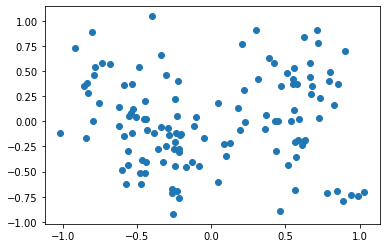

In [440]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pyclustertend import hopkins

pca = PCA(n_components=2)
pca.fit(merged.drop('gname',axis=1))
print(f"Principal components: {pca.explained_variance_ratio_}")
transformed = pd.DataFrame(pca.fit_transform(merged.drop('gname',axis=1)))
print(f"Clustering tendency: {hopkins(merged.drop('gname',axis=1),50)}")
transformed.columns = ['comp1','comp2']
plt.scatter(transformed['comp1'],transformed['comp2'])

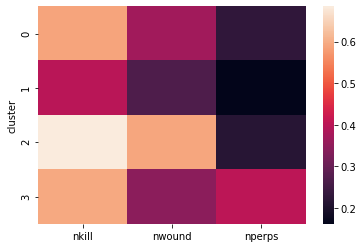

In [400]:
features_c, feature_c_stats = getClusterStats(merged.drop(['gname'],axis=1), 4, ['nkill','nwound','nperps'])

In [387]:
features_c['cluster'].value_counts()

3    38
0    36
2    26
1    26
Name: cluster, dtype: int64

Principal components: [0.68293544 0.1931972 ]
Clustering tendency: 0.19783895746708796


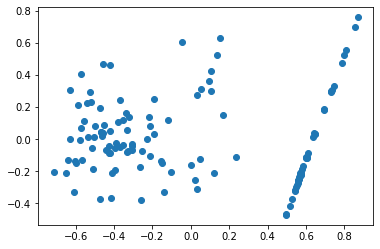

In [456]:
# zoom into some features (I)
cols_s1 = ['nwound','nkill','avg_propvalue','prop','suicide']
merged_features_s1 = merged[cols_s1]
pca_s1 = PCA(n_components=2)
pca_s1.fit(merged_features_s1)
print(f"Principal components: {pca_s1.explained_variance_ratio_}")
print(f"Clustering tendency: {hopkins(merged_features_s1,50)}")
transformed_s1 = pd.DataFrame(pca.fit_transform(merged_features_s1))
transformed_s1.columns = ['comp1','comp2']
plt.scatter(transformed_s1['comp1'],transformed_s1['comp2'])

<ipython-input-378-61646eb0a7cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['cluster'] =  cluster.fit_predict(features)


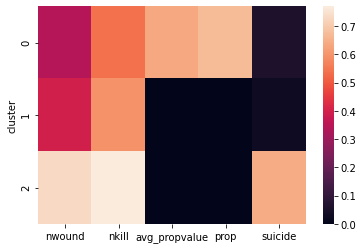

In [457]:
merged_features_s1_c, merged_features_s1_c_stats = getClusterStats(merged_features_s1, 3, cols_s1)

In [458]:
merged_features_s1_c['cluster'].value_counts()

0    83
1    33
2    10
Name: cluster, dtype: int64

Principal components: [0.45569072 0.23489604]
Clustering tendency: 0.22807781835570312


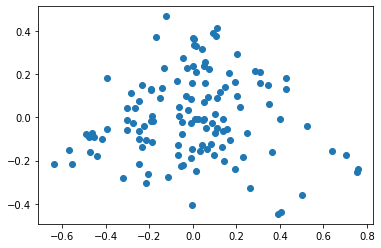

In [474]:
# zoom into some features (II)
cols_s2 = ['nkill','nperps','atk_bombing','atk_host_kid']
merged_features_s2 = merged[cols_s2]
pca_s2 = PCA(n_components=2)
pca_s2.fit(merged_features_s2)
print(f"Principal components: {pca_s2.explained_variance_ratio_}")
print(f"Clustering tendency: {hopkins(merged.drop('gname',axis=1),50)}")
transformed_s2 = pd.DataFrame(pca.fit_transform(merged_features_s2))
transformed_s2.columns = ['comp1','comp2']
plt.scatter(transformed_s2['comp1'],transformed_s2['comp2'])

<ipython-input-378-61646eb0a7cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['cluster'] =  cluster.fit_predict(features)


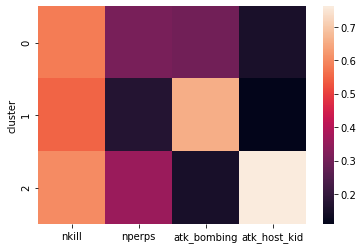

In [475]:
merged_features_s2_c, merged_features_s2_c_stats = getClusterStats(merged_features_s2, 3, cols_s2)

In [476]:
merged_features_s2_c['cluster'].value_counts()

0    72
1    44
2    10
Name: cluster, dtype: int64

Principal components: [0.36171867 0.16964944]
Clustering tendency: 0.2420327966459765


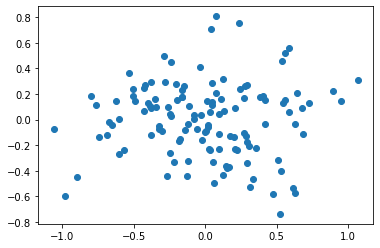

In [482]:
# zoom into some features (III)
cols_s3 = ['nkill','nperps','suicide',"atk_armed_assault", "atk_bombing", "atk_host_barr",
           "wp_explosives", "wp_firearms","wp_incendiary","tg_gov_gen","tg_private",
           "tg_military"
          ]
merged_features_s3 = merged[cols_s3]
pca_s3 = PCA(n_components=2)
pca_s3.fit(merged_features_s3)
print(f"Principal components: {pca_s3.explained_variance_ratio_}")
print(f"Clustering tendency: {hopkins(merged.drop('gname',axis=1),50)}")
transformed_s3 = pd.DataFrame(pca.fit_transform(merged_features_s3))
transformed_s3.columns = ['comp1','comp2']
plt.scatter(transformed_s3['comp1'],transformed_s3['comp2'])

<ipython-input-378-61646eb0a7cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['cluster'] =  cluster.fit_predict(features)


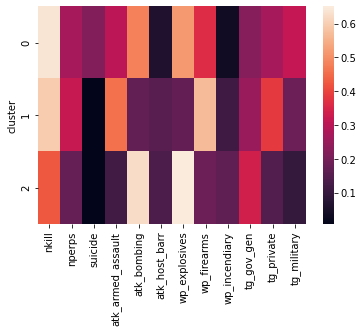

In [483]:
merged_features_s3_c, merged_features_s3_c_stats = getClusterStats(merged_features_s3, 3, cols_s3)

In [485]:
merged_features.corr()

,nperps,nkill,nwound,atk_armed_assault,atk_assasination,atk_bombing,atk_faci_infra,atk_hijack,atk_host_barr,atk_host_kid,atk_unarmed_assault,atk_unknown,wp_chemical,wp_explosives,wp_fake,wp_firearms,wp_incendiary,wp_melee,wp_other,wp_sabotage_equip,wp_unknown,wp_vehicle,tg_abortion,tg_air,tg_business,tg_edu,tg_food_water,tg_gov_dip,tg_gov_gen,tg_media,tg_Mmritime,tg_military,tg_ngo,tg_other,tg_police,tg_private,tg_religious,tg_telecom,tg_terror_militia,tg_tourists,tg_transport,tg_unknown,tg_utilities,tg_violent_pp,success,suicide,prop,avg_propvalue,time_diff_mean,time_diff_std
nperps,1.000000,0.292464,0.007127,0.424054,-0.299064,-0.311385,-0.030909,-0.041056,0.021796,0.247201,-0.078708,0.433814,-0.160981,-0.332818,-0.054988,0.230929,-0.034236,-0.082564,0.001138,-0.055211,0.417038,-0.119080,-0.127755,-0.120027,-0.183876,0.050059,0.194284,-0.082913,-0.123344,0.015155,0.217970,0.215913,0.181827,-0.037326,-0.084850,0.038503,0.048646,0.024963,-0.145647,0.022319,0.173824,-0.124640,0.187922,-0.081914,0.346294,-0.289223,0.236071,0.136158,-0.183958,-0.102342
nkill,0.292464,1.000000,0.688567,0.402196,-0.124991,-0.118823,-0.459099,0.013779,-0.045544,0.189425,-0.143692,0.320986,-0.195078,-0.083179,-0.078296,0.281607,-0.461729,-0.106989,-0.179317,-0.116928,0.280251,-0.079867,-0.246286,-0.071604,-0.423146,0.147409,0.034437,0.012644,-0.247547,-0.113734,0.236627,0.351610,0.223412,0.165036,-0.025956,0.201131,0.002918,-0.205137,0.190342,-0.099116,0.122732,-0.164081,-0.023147,-0.159275,0.263461,0.421062,-0.247156,-0.218825,-0.321357,-0.296956
nwound,0.007127,0.688567,1.000000,0.137116,-0.265595,0.153249,-0.308097,0.106234,-0.092701,0.142764,-0.054238,0.159285,0.030699,0.208698,-0.037370,-0.092411,-0.334023,0.017420,-0.027806,0.023926,0.107110,0.017340,-0.154637,0.065879,-0.355599,0.051629,0.050370,0.109263,-0.297089,-0.209708,0.099373,0.227923,0.138570,0.237059,-0.052910,0.219699,0.144347,-0.195374,0.221854,0.020549,-0.012754,-0.072955,-0.061259,-0.098821,0.090482,0.675162,-0.316270,-0.323410,-0.240847,-0.273835
atk_armed_assault,0.424054,0.402196,0.137116,1.000000,-0.215452,-0.583190,-0.220913,-0.036607,0.055745,0.103889,0.159780,0.068177,-0.123242,-0.587804,-0.136642,0.670330,-0.201453,0.265196,-0.136856,-0.056754,0.036123,0.232211,-0.126938,-0.211057,-0.424459,0.031390,-0.043882,-0.217920,-0.242617,-0.076498,0.233974,0.371683,0.088093,0.013293,0.084391,0.217696,0.075057,-0.058132,-0.206667,-0.071688,0.127425,-0.130980,-0.051705,-0.007904,0.268180,-0.076280,-0.038899,-0.134259,-0.086272,-0.035324
atk_assasination,-0.299064,-0.124991,-0.265595,-0.215452,1.000000,-0.295904,-0.094887,-0.104878,-0.002383,-0.285528,-0.049949,-0.204135,-0.117262,-0.227169,-0.059235,0.393716,-0.071956,-0.060501,-0.020151,-0.107196,-0.142193,-0.065134,-0.058882,0.081180,0.065039,-0.011434,-0.128904,0.261584,0.208925,0.100192,-0.072913,-0.296510,0.013785,0.143226,0.152410,0.071686,-0.045302,0.095197,0.152844,0.014783,-0.126799,-0.091897,-0.193446,0.015476,-0.196772,-0.168877,-0.059624,0.161344,0.118738,0.178119
atk_bombing,-0.311385,-0.118823,0.153249,-0.583190,-0.295904,1.000000,-0.231293,-0.019111,-0.055089,-0.267812,-0.246489,-0.291643,-0.014342,0.960743,-0.109334,-0.652283,-0.250494,-0.302700,-0.033649,0.020639,-0.355273,-0.133283,-0.097823,0.202978,0.265447,-0.164325,0.161501,0.068491,0.150439,-0.010681,-0.090658,0.008681,-0.282786,-0.035761,-0.049555,-0.362009,-0.071386,-0.014180,0.070982,0.070178,0.059093,0.182022,0.295220,-0.066230,-0.041810,0.241088,0.061521,0.036986,-0.109603,-0.158714
atk_faci_infra,-0.030909,-0.459099,-0.308097,-0.220913,-0.094887,-0.231293,1.000000,-0.049067,-0.064546,-0.165821,0.109595,-0.052398,0.450902,-0.263441,0.555898,-0.277806,0.948641,0.085943,0.189122,0.239123,-0.083087,0.009596,0.539293,-0.075734,0.298674,0.277022,-0.075393,-0.109986,0.040034,-0.083836,-0.130750,-0.254359,0.002600,-0.113729,-0.096086,-0.130351,0.114013,0.116580,-0.114606,-0.040858,-0.114862,0.052255,-0.122876,0.087436,-0.211002,-0.185205,0.219314,0.182514,0.24934

In [ ]:
"atk_armed_assault", "atk_bombing", "atk_host_barr"
"wp_explosives", "wp_firearms","wp_incendiary"
"tg_gov_gen","tg_private","tg_military"